## Description
This script builds a multi-input model to predict percentage change in muscle mass in participants from 5 studies who performed 10-13 weeks of progressive resistance exercise training. The percentage change in muscle mass per dataset is ranked 0-1 as shown in https://github.com/phoebemma/ML_paper/blob/main/data_preprocessing.ipynb

The model takes as input Age, BMI, Volume of exercise, and the gene expression data. 

In [1]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import to_categorical
import pydot

from scipy.stats import norm
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
shap.initjs()

In [2]:
# Load the data containing the genecounts
genecounts = pd.read_csv("full_genecounts.csv")
# Initialise the scaler
scaler = StandardScaler()
# scale the genecounts 
genecounts_scaled = scaler.fit_transform(genecounts.iloc[:, 1:])
genecounts_scaled = pd.DataFrame(genecounts_scaled, columns = genecounts.columns[1:])

genecounts_scaled.insert(0, 'gene_id', genecounts['gene_id'])
genecounts_scaled = genecounts_scaled.set_index("gene_id")
genecounts_scaled = genecounts_scaled.T
genecounts_scaled = genecounts_scaled.reset_index().rename(columns = {"index": "seq_sample_id"})
genecounts_scaled = genecounts_scaled.round(2)
genecounts_scaled

gene_id,seq_sample_id,ENSG00000000003.16,ENSG00000000419.14,ENSG00000000457.14,ENSG00000000971.17,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.15,ENSG00000001461.18,ENSG00000001497.18,...,ENSG00000308270.1,ENSG00000309097.1,ENSG00000309174.1,ENSG00000309618.1,ENSG00000310376.1,ENSG00000310517.1,ENSG00000310523.1,ENSG00000310526.1,ENSG00000310527.1,ENSG00000310533.1
0,s104,-1.22,0.09,-0.74,-0.21,-0.98,-0.41,-0.51,-0.46,0.25,...,-0.61,-1.12,-1.09,-1.25,0.45,1.69,-0.17,-0.06,-0.03,-1.34
1,s112,-0.96,0.11,-0.70,0.09,-0.77,0.02,-0.33,-0.44,0.02,...,-0.40,-1.53,-1.08,-1.24,-0.05,1.82,-0.22,0.43,0.25,-1.12
2,s13,-1.23,0.09,-0.72,-0.21,-0.86,-0.43,-0.45,-0.58,0.11,...,-0.71,-1.55,-1.48,-1.43,0.94,1.43,0.14,0.50,0.49,-1.18
3,s130,-1.29,-0.00,-0.49,-0.08,-1.13,-0.47,-0.42,-0.83,0.31,...,-1.27,-1.40,-0.69,-1.03,0.83,1.76,0.24,0.48,0.41,-1.21
4,s136,-1.06,0.13,-0.63,0.02,-0.79,-0.28,-0.46,-1.11,0.16,...,-0.80,-1.38,-1.19,-0.96,0.65,1.79,-0.26,0.02,-0.03,-1.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,FP6w0R,-0.58,0.55,-0.41,0.31,-0.78,-0.11,-0.20,0.00,0.31,...,-0.06,-1.17,-0.81,-0.52,2.96,1.74,-0.99,-0.68,-0.81,-0.84
285,FP7w0L,-0.93,0.61,-0.50,0.12,-0.93,-0.20,-0.41,-0.21,0.24,...,0.43,-0.72,-1.38,-0.46,2.97,1.77,-1.16,-0.59,-0.90,-1.16
286,FP7w0R,-0.84,0.60,-0.67,0.16,-0.95,-0.24,-0.51,-0.23,0.24,...,0.29,-0.84,-1.13,-0.52,2.96,1.78,-0.76,-0.24,-0.71,-1.35
287,FP9w0R,-0.90,0.59,-0.47,-0.18,-0.81,-0.49,-0.34,-0.34,0.39,...,0.57,-0.93,-1.64,-0.26,2.92,1.86,-0.53,-0.10,-0.40,-1.32


In [3]:
# Load the full metadata
full_metadata = pd.read_csv("full_metadata.csv")
# round scaled percentage change to 2 decimal places 
full_metadata["scaled_pct_change"] = full_metadata["scaled_pct_change"].round(2)
# select onnly the variables needed for the model
metadata_full = full_metadata[["seq_sample_id", "age", "BMI", "scaled_pct_change", "category", "volume", "condition"]]
metadata_full

,seq_sample_id,age,BMI,scaled_pct_change,category,volume,condition
0,s104,46.0,29.0,0.42,Average_responder,3,RM10
1,s112,53.0,30.3,0.33,Average_responder,3,RM10
2,s13,46.0,25.3,0.92,High_responder,3,RM10
3,s130,58.0,29.9,0.26,Average_responder,3,RM10
4,s136,48.0,18.4,0.66,Average_responder,3,RM10
...,...,...,...,...,...,...,...
456,FP6w0R,21.8,20.5,0.09,No_responder,1,RM10
457,FP7w0L,21.2,28.2,0.73,Average_responder,3,RM10
458,FP7w0R,21.2,28.2,0.94,High_responder,1,RM10
459,FP9w0R,20.6,21.2,0.65,Average_responder,3,RM10


In [4]:
# join the gene expression data and the metadata
df = metadata_full.merge(genecounts_scaled, on = "seq_sample_id")
df = df.sort_values(by = "seq_sample_id")
df

,seq_sample_id,age,BMI,scaled_pct_change,category,volume,condition,ENSG00000000003.16,ENSG00000000419.14,ENSG00000000457.14,...,ENSG00000308270.1,ENSG00000309097.1,ENSG00000309174.1,ENSG00000309618.1,ENSG00000310376.1,ENSG00000310517.1,ENSG00000310523.1,ENSG00000310526.1,ENSG00000310527.1,ENSG00000310533.1
412,FP11w0L,22.3,23.6,0.04,No_responder,1,RM10,-0.91,0.52,-0.40,...,0.01,-0.74,-1.07,-0.65,3.28,2.06,-0.64,-0.18,-0.74,-1.32
411,FP11w0R,22.3,23.6,0.16,Average_responder,3,RM10,-0.80,0.46,-0.32,...,-0.07,-0.98,-0.94,-0.80,3.28,2.13,-0.66,-0.20,-0.91,-1.22
414,FP12w0L,21.3,22.8,0.20,Average_responder,1,RM10,-0.73,0.56,-0.63,...,-0.29,-0.69,-1.12,-0.55,2.84,1.71,-0.53,-0.50,-0.52,-1.14
413,FP12w0R,21.3,22.8,0.11,No_responder,3,RM10,-0.68,0.45,-0.70,...,-0.23,-0.78,-1.23,-0.26,2.78,1.68,-0.54,-0.01,-0.39,-1.61
415,FP13w0L,22.7,19.8,0.99,High_responder,3,RM10,-0.70,0.57,-0.80,...,-0.42,-0.80,-1.23,-0.55,2.87,1.72,-0.92,0.06,-0.10,-0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,s891,54.0,21.8,0.47,Average_responder,3,RM30,-1.02,0.08,-0.64,...,-0.93,-1.82,-0.89,-1.47,-0.25,1.57,0.04,0.41,0.38,-1.02
165,s903,42.0,27.3,0.82,High_responder,3,RM30,-0.95,0.07,-0.56,...,-0.61,-1.89,-1.03,-1.40,-0.25,1.52,-0.16,0.35,0.06,-1.64
81,s903,42.0,27.3,0.25,Average_responder,3,RM10,-0.95,0.07,-0.56,...,-0.61,-1.89,-1.03,-1.40,-0.25,1.52,-0.16,0.35,0.06,-1.64
82,s96,48.0,27.7,0.32,Average_responder,3,RM10,-0.89,0.30,-0.57,...,-0.84,-1.93,-1.41,-1.46,0.59,1.64,-0.06,0.25,0.35,-1.13


In [5]:
#duplicates = metadata_full[metadata_full.duplicated("seq_sample_id", keep = False)]
#duplicates = duplicates.sort_values(by = "seq_sample_id")
#duplicates

This model would have 4 inputs; the gene expression counts, the age and BMI of participants. The aim is for the model to learn the contribution of the  individual factors  in leading to increase in muscle mass

In [6]:
# Input 1; the gene expression data
X_gene = df.drop(["seq_sample_id", "age", "BMI",
                  "scaled_pct_change", "category", "volume", "condition"],axis = 1)
X_gene = np.array(X_gene)
# Input 2; volume of exercise
X_vol = df["volume"]
X_vol = np.array(X_vol)

# input 3; age of participants
X_age = df["age"]
X_age = np.array(X_age)

# input 4 BMI of participants
X_BMI = df["BMI"]
X_BMI = np.array(X_BMI)

# Predicted variable
y = df["scaled_pct_change"]
y = np.array(y)

X_gene_train, X_gene_test, X_vol_train, X_vol_test, X_age_train, X_age_test, X_BMI_train, X_BMI_test, y_train, y_test = train_test_split(X_gene, X_vol, X_age, X_BMI, y, test_size = 0.2, random_state = 123  )

# From the train data create the validation dataset
X_gene_train, X_gene_val, X_vol_train, X_vol_val, X_age_train, X_age_val, X_BMI_train, X_BMI_val, y_train, y_val = train_test_split(X_gene_train, X_vol_train, X_age_train, X_BMI_train, y_train,  test_size = 0.2, random_state = 123)






In [7]:
X_gene_train

array([[-0.83,  0.07, -0.65, ...,  0.4 ,  0.21, -1.27],
       [-0.84,  0.49, -0.34, ..., -0.76, -1.14, -1.37],
       [-0.74,  0.19, -0.39, ..., -0.96, -1.07, -1.  ],
       ...,
       [-1.1 ,  0.14, -0.68, ...,  0.22,  0.08, -1.4 ],
       [-0.88,  0.14, -0.45, ...,  0.44,  0.3 , -1.3 ],
       [-0.99,  0.02, -0.55, ...,  0.52,  0.56, -1.44]])

In [8]:
X_vol_train

array([1, 3, 0, 3, 0, 3, 1, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 6, 3, 6, 3, 3,
       3, 3, 3, 3, 0, 1, 3, 1, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3,
       3, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 1, 0, 0, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 6, 3, 3, 3,
       3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       3, 1, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       6, 3, 6, 3, 0, 3, 1, 3, 3, 1, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0,
       3, 3, 3, 1, 1, 3, 3, 3, 0, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3,
       1, 1, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3,
       3, 3, 1, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 6, 3, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 6,
       3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)

In [9]:
X_age_train

array([21. , 71.8, 20. , 55. , 35. , 67.5, 21.3, 23.7, 23. , 24. , 45. ,
       21. , 23.6, 54. , 22.9, 48. , 46. , 28. , 55. , 27. , 66. , 66.8,
       43. , 68.8, 79. , 56. , 26. , 23. , 45. , 74. , 20. , 71. , 48. ,
       42. , 24.8, 21.2, 27. , 74.6, 30. , 70. , 72.4, 44. , 64.3, 53. ,
       20. , 23. , 79. , 67.5, 51. , 44. , 24. , 73. , 46. , 46. , 69.9,
       28. , 53. , 28. , 35. , 64.3, 45. , 49. , 49. , 28. , 45. , 47. ,
       53. , 58. , 72. , 22.8, 28. , 22. , 24. , 37.4, 70. , 59. , 50. ,
       48. , 24.5, 26.8, 70.3, 22.1, 35. , 68.8, 23. , 58.9, 46. , 44. ,
       49. , 81. , 21. , 33. , 22. , 65.8, 65.6, 21.8, 60.2, 59. , 43. ,
       66. , 55. , 56. , 37. , 59. , 69.9, 58. , 42. , 60. , 46. , 73. ,
       72.3, 20. , 62. , 35. , 49. , 52. , 71.8, 69.6, 51. , 22.7, 25. ,
       71. , 68. , 56.7, 48. , 46. , 47. , 48. , 22.3, 51. , 49. , 21. ,
       24. , 56. , 26. , 45. , 26. , 24. , 74. , 86. , 45. , 79. , 21. ,
       53. , 58. , 60.2, 73.7, 54. , 21.2, 38. , 24

In [10]:
X_BMI_train

array([24.5, 23.4, 26.2, 24.7, 27.3, 28.4, 22.8, 26.5, 23.7, 23.1, 25.9,
       21.2, 21.1, 21.8, 25.2, 24.3, 31. , 38.9, 24.7, 18.1, 29.3, 25.4,
       31.6, 27.8, 19.3, 31. , 22.8, 21.9, 29.1, 20.7, 26. , 26.2, 31.6,
       26.6, 22. , 28.2, 25.9, 23.4, 24.6, 24.7, 30.9, 27.9, 23.2, 30.3,
       22.7, 25.2, 26. , 28.4, 39.5, 24.4, 29.4, 27.4, 29. , 25.3, 26.9,
       28. , 25.3, 23.6, 29.3, 22.4, 26.6, 29.8, 28.5, 30.6, 29.5, 28.6,
       24.4, 28.5, 27.4, 23.1, 38.9, 22.9, 29.2, 19.4, 25.7, 23.3, 28.1,
       34.8, 23. , 25.1, 24.1, 24.1, 29.3, 27.8, 23.4, 22. , 24.6, 22. ,
       28.5, 22.6, 28.6, 32.4, 22.9, 36.6, 19.5, 20.5, 29. , 30. , 32.3,
       29.3, 33.5, 22.2, 25.9, 39.9, 26.9, 28.4, 26.6, 25.4, 25.3, 22.2,
       24.3, 22.7, 25.3, 27.3, 29.8, 27.8, 23.4, 24.2, 41.8, 19.8, 18.8,
       26.2, 21.6, 21. , 27.7, 36.8, 26.5, 34.8, 23.6, 31.7, 21.2, 19.6,
       31.2, 27.5, 22.8, 29.1, 24.4, 46.2, 29.1, 25.9, 38.3, 19.3, 28.6,
       25.3, 28.4, 22.2, 24.8, 21.8, 28.2, 26.4, 23

In [11]:
print(y_train.shape)

(294,)


## The model

In [13]:


gene_input = Input(shape =(10926,), name = "gene_counts")
x1  = Dense(128, activation = "relu")(gene_input)

vol_input = Input(shape = (1,), name = "volume")
x2 = Dense(8, activation= "relu")(vol_input)

age_input = Input(shape =(1,), name = "age")
x3 = Dense(8, activation= "relu")(age_input)

BMI_input = Input(shape = (1,), name = "BMI")
x4 = Dense(8, activation ="relu")(BMI_input)



# Concatenate all processed inputs
combined = Concatenate()([x1, x2, x3, x4])

# Add further Dense layers
z = Dense(64, activation='relu')(combined)
z = Dense(32, activation='relu')(z)


# output layer, target is continous but bounded (0-1)

output = Dense(1, activation = "sigmoid")(z)


In [14]:
# Build and complie model
multi_model = Model(inputs = [gene_input, vol_input, age_input, BMI_input],
             outputs = output)

multi_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss = tf.keras.losses.Huber(delta = 0.5),
    metrics=["mean_squared_error", "mae"]   
)

In [15]:
multi_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                 ┃ Output Shape              ┃         Param # ┃ Connected to              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gene_counts (InputLayer)     │ (None, 10926)             │               0 │ -                         │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ volume (InputLayer)          │ (None, 1)                 │               0 │ -                         │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ age (InputLayer)             │ (None, 1)                 │               0 │ -                         │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ BMI (InputLayer)             │ (None, 1)                 │               0 │ -                         │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ dense (Dense)                │ (None, 128)               │       1,398,656 │ gene_counts[0][0]         │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ dense_1 (Dense)              │ (None, 8)                 │              16 │ volume[0][0]              │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ dense_2 (Dense)              │ (None, 8)                 │              16 │ age[0][0]                 │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ dense_3 (Dense)              │ (None, 8)                 │              16 │ BMI[0][0]                 │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ concatenate (Concatenate)    │ (None, 152)               │               0 │ dense[0][0],              │
│                              │                           │                 │ dense_1[0][0],            │
│                              │                           │                 │ dense_2[0][0],            │
│                              │                           │                 │ dense_3[0][0]             │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ dense_4 (Dense)              │ (None, 64)                │           9,792 │ concatenate[0][0]         │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ dense_5 (Dense)              │ (None, 32)                │           2,080 │ dense_4[0][0]             │
├──────────────────────────────┼───────────────────────────┼─────────────────┼───────────────────────────┤
│ dense_6 (Dense)              │ (None, 1)                 │              33 │ dense_5[0][0]             │
└──────────────────────────────┴───────────────────────────┴─────────────────┴───────────────────────────┘

 Total params: 1,410,609 (5.38 MB)

 Trainable params: 1,410,609 (5.38 MB)

 Non-trainable params: 0 (0.00 B)

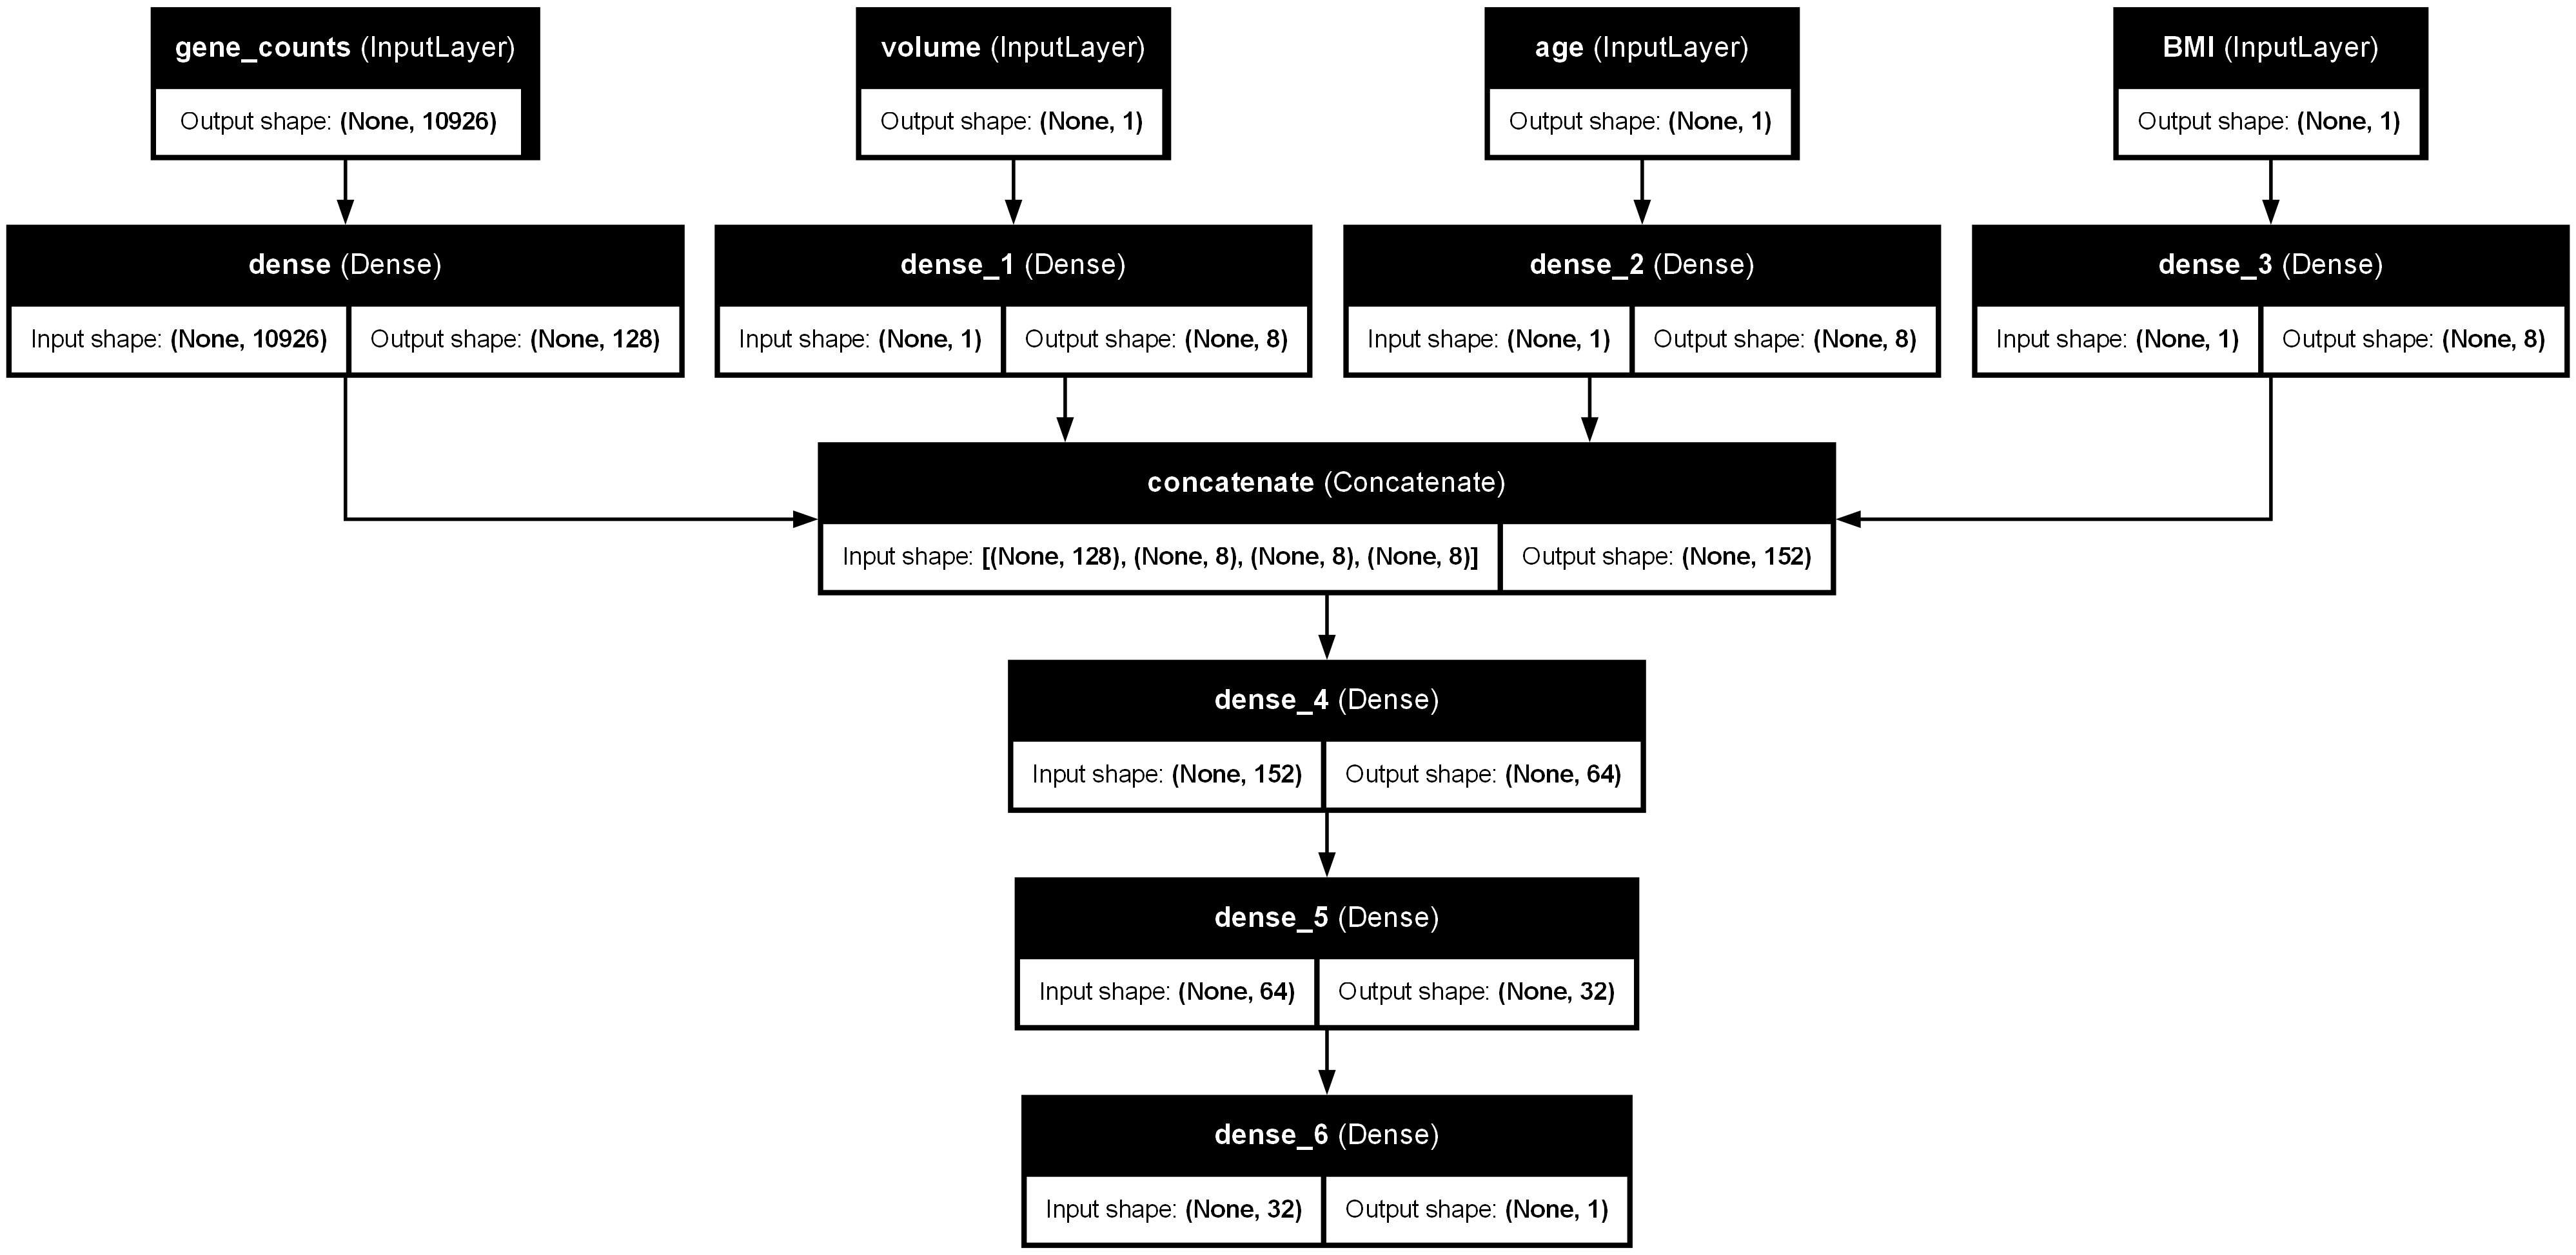

In [16]:
tf.keras.utils.plot_model(multi_model, show_shapes=True, show_layer_names=True)

In [17]:

# Define the callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)



# Train the model
history= multi_model.fit(
    x = {"gene_counts": X_gene_train,
      "volume" : X_vol_train,
      "age" : X_age_train,
      "BMI": X_BMI_train },
    
    y = y_train,
    validation_data = (
        {"gene_counts": X_gene_val,
      "volume" : X_vol_val,
      "age" : X_age_val,
      "BMI": X_BMI_val },
        y_val
    ),
    epochs = 40,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0995 - mae: 0.3912 - mean_squared_error: 0.2118 - val_loss: 0.0233 - val_mae: 0.1743 - val_mean_squared_error: 0.0467
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0216 - mae: 0.1713 - mean_squared_error: 0.0434 - val_loss: 0.0214 - val_mae: 0.1569 - val_mean_squared_error: 0.0433
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0192 - mae: 0.1536 - mean_squared_error: 0.0386 - val_loss: 0.0201 - val_mae: 0.1524 - val_mean_squared_error: 0.0405
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0207 - mae: 0.1567 - mean_squared_error: 0.0419 - val_loss: 0.0197 - val_mae: 0.1576 - val_mean_squared_error: 0.0395
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0175 - mae: 0.1459 - mean_squared_error: 0.0353 - val_loss: 0.0185 - val_mae: 0.1502 - val_mean_squared_error: 0.0370
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0150 - mae: 0.1357 - mean_squared_error: 0.0

In [18]:
results = multi_model.evaluate(
    x = {"gene_counts" : X_gene_val,
        "volume" : X_vol_val,
        "age" : X_age_val,
        "BMI" : X_BMI_val},
   y= y_val
)
print("\nEvaluation results:")
for name, value in zip(multi_model.metrics_names, results):
    print(f"{name}:{value:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0194 - mae: 0.1495 - mean_squared_error: 0.0390

Evaluation results:
loss:0.0172
compile_metrics:0.0345


## Feature engineering

In [21]:

# Use a small subset of training data as background for SHAP
background_data = np.concatenate([
    X_gene_train[:10],
    X_vol_train[:10].reshape(-1, 1),
    X_age_train[:10].reshape(-1, 1),
    X_BMI_train[:10].reshape(-1, 1)
], axis=1)


# Create SHAP explainer
#explainer = shap.KernelExplainer(model.predict, background_data)

# Compute SHAP values
#shap_values = explainer.shap_values([X_gene_test, X_vol_test, X_age_test, X_BMI_test])

# Visualize feature importance
#shap.summary_plot(shap_values, [X_gene_train, X_vol_train, X_age_train, X_BMI_train],
#                  feature_names=['gene_counts', 'volume', 'age', 'BMI'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  0%|          | 0/93 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
7471/7471 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
7471/7471 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
7471/7471 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
7471/7471 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
7471/7471 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7471/7471 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
7471/7471 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
7471/7471 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
7471/7471 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7471/7471 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7471/7471 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
7471/7471 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
1/1 ━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>

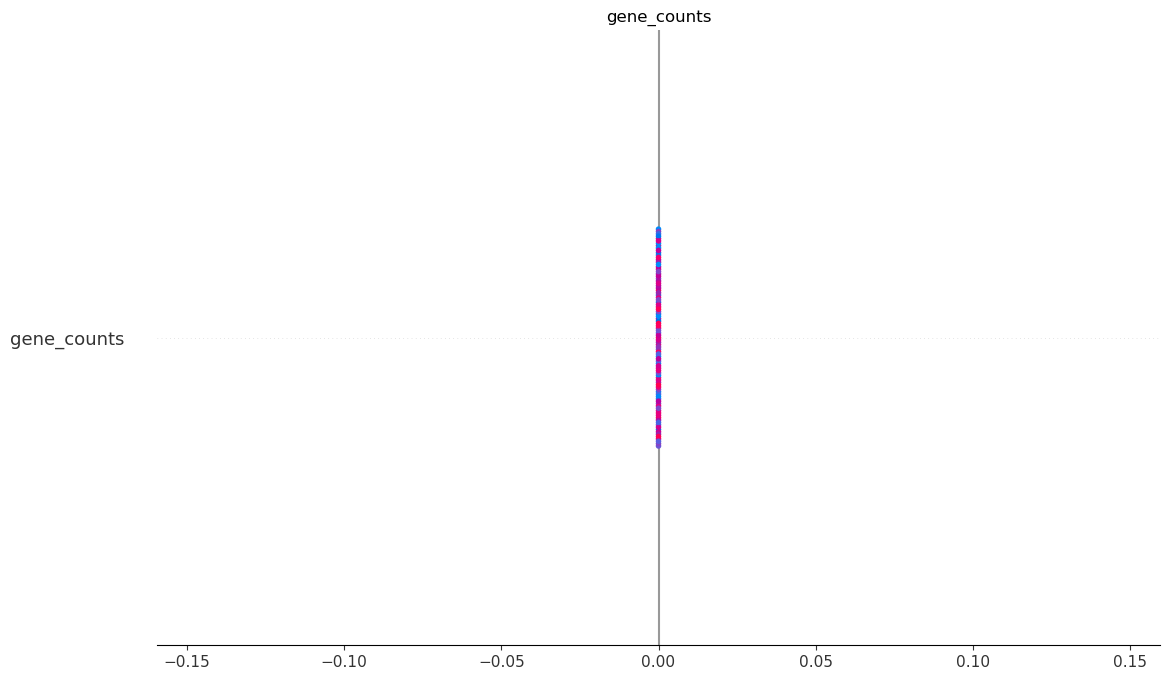

In [22]:

# Define a prediction wrapper for SHAP
def model_predict(X):
    gene = X[:, :10926]
    volume = X[:, 10926:10927]
    age = X[:, 10927:10928]
    bmi = X[:, 10928:]
    return model.predict([gene, volume, age, bmi])

# Concatenate test data 
test_data = np.concatenate([X_gene_test, X_vol_test.reshape(-1, 1), X_age_test.reshape(-1, 1), X_BMI_test.reshape(-1, 1)], axis=1)

# initialise explainer
explainer = shap.KernelExplainer(model_predict, background_data)

# Compute SHAP values
shap_values = explainer.shap_values(test_data)

# Visualize feature importance
shap.summary_plot(shap_values, test_data, feature_names=['gene_counts', 'volume', 'age', 'BMI'])
